<a href="https://colab.research.google.com/github/DuyDucNguyen/Practical_FEM_FEniCS_Colab/blob/master/semiconductor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semicondoctor device

In [0]:
# This program shows how to implement Drift-Diffusion model in Fenics, material Silicon

# Copyright (C) 2019 Duy Duc NGUYEN (duyduc.nguyen@protonmail.com)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2019-09-23
# Last changed: 2019-09-23

# This demo is maintained by Duy Duc NGUYEN
# Please report possible problems to duyduc.nguyen@protonmail.com

In [1]:
# install Fenics: 2 mins
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

E: Package 'python-software-properties' has no installation candidate
Get:1 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [564 B]
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  R

**Drift-Diffusion Model**

\begin{equation}
\begin{cases}
\varepsilon\nabla\cdot\boldsymbol{E}=\dfrac{q_{e}}{\varepsilon_{0}}\left(p-n\right) & \text{ in }\Omega_{0}\times\left(0,t_{end}\right]\\
\dfrac{\partial n}{\partial t}+\nabla\cdot\boldsymbol{j}_{n}=S_{n}-R & \text{ in }\Omega_{0}\times\left(0,t_{end}\right]\\
\dfrac{\partial p}{\partial t}+\nabla\cdot\boldsymbol{j}_{p}=S_{p}-R & \text{ in }\Omega_{0}\times\left(0,t_{end}\right]
\end{cases}
\end{equation}

\begin{equation}
\boldsymbol{j}_{n}=n\left(-\mu_{n}\boldsymbol{E}\right)-D_{n}\nabla n\text{ and }\boldsymbol{j}_{p}=p\left(\mu_{p}\boldsymbol{E}\right)-D_{p}\nabla p
\end{equation}

where where $\Omega$ is semiconductor body, $t\in\left(0,t_{end}\right]$
is time variable, $p$ and $n$ are hole and electron densities respectively,
$\boldsymbol{E}=-\nabla\varphi$ is electric field and $\varphi$
is potential, $\varepsilon_{0}$ is absolute permittivity of the vacuum
and $\varepsilon$ is relative permittivity, $q_{e}$ is the elementary
charge, $\boldsymbol{j}_{n}$ and $\boldsymbol{j}_{p}$ are density
currents, $S_{n}$ and $S_{p}$ are sources of electron and hole and
$R$ is recombination function. The electrons are the only particles
that will emit from the semiconductor's surface and also the only
source of electrons in vacuum.

The holes source term $S_{p}$ is assumed
to be a small fraction of $S_{n}$
\begin{equation}
S_{n}=\frac{I_{0}}{q(2\pi)^{3/2}\sigma_{x}\sigma_{y}\sigma_{z}}exp\left(-\left(\frac{\left(x-Bx\right)^{2}}{\sigma_{x}^{2}}+\frac{\left(y-By\right)^{2}}{\sigma_{y}^{2}}+\frac{\left(z-(Bz-0.3P)\right)^{2}}{\sigma_{z}^{2}}\right)\right),S_{p}=S_{n}
\end{equation}

The recombination term, denoted by $R$, follows the Shockley-Read-Hall model formulated
as 
\begin{equation}
R\left(n^{0},p^{0}\right)=\frac{n^{0}p^{0}-n_{i}^{2}}{\tau_{p}\left(n^{0}+n_{i}\right)+\tau_{n}\left(p^{0}+p_{i}\right)}
\end{equation}
where $n_{i}$ and $p_{i}$ are the intrinsic carrier concentration,
$\tau_{n}$ and $\tau_{p}$ the electron and hole average lifetimes. 


In [2]:
# All Material Parameters
# International Unity
import math


k = 1.38064852E-23           # (CV/K) Boltzmann constant
T = 300.0                    # (K) Temperature
qe = 1.6E-19                 # (C) Elementary charge


def einstein_relation(Mu):
  return k*T*Mu/qe


eps0 = 8.854E-12             # (C/(V*m)) Absolute permittivity of vacuum


#me = 9.109E-31		           # (kg): Electron mass (Wiki)
me = 0.9109383701584688E-30  # CVns^2/nm^2: electron mass (Wiki)



Si = {
	'name': 'Silicon',
	'symbol' : 'Si',
	'eps' : 11.68, 			# (Null): Relative permittivity of Si
	'Mun': 1400.0,		# (cm^2/(V*s)): Electron mobility of Si
	'Mup': 450.0,		# (cm^2/(V*s)): Hole mobility of Si
	'ni'  : 1E-11,			# (nm^-3) Intrinsic electron concentration in Silicon
	'pi'  : 1E-11, 			# (nm^-3) Intrinsic hole concentration in Silicon
	"vn"  : 7.0,			# raftari2015 ASSUMPTION (nm/ns) Surface Recombination Velocity of Electron
	"vp"  : 0.0,			# Hole does not exist in Vacuum
	"rho" : 2.329,			# (g/cm^3) Mass density Cite: Wiki
	"Nv" : 1.8E-2,         # (nm^-3): Effective density of states, valence band
	"Nc" : 3.2E-2,         # (nm^-3): Effective density of states, conductor band
	"Eg" : qe*1.12        # (V): Band gap
	}


# D_n: (nm^2/ns) 36E5 Electron diffusion coefficient of Si
Si = dict( Si.items() |
	{	'Dn' : einstein_relation(Si['Mun']),
		'Dp' : einstein_relation(Si['Mup']),
		"n1": Si["Nc"]*math.exp( - (2.0/3.0)*(Si["Eg"]*qe)/(k*T) ),
		"p1": Si["Nv"]*math.exp( - (1.0/3.0)*(Si["Eg"]*qe)/(k*T) )
	}.items() )



tau_n = 1E4      # (ns): electron lifetime
tau_p = 1E4      # (ns): hole lifetime


tol = 1E-14


# Time variable
dt_num = 10.0                                # Number of time step

del_d  = 2.0                                # (nm): Real distace between two spots


I_0  = 1.0E-15                # (C/ns)        : Incident electron current
#I_0  = 100.0             # (C/ns)        : Incident electron current
r_i  = 10.0                   # (nm)          : Spot size
source_cof = 4.0*math.log(2.0, math.e)





# ======================= Change Unity to [nm, ns] =======================================
def con_uni(x, a='m', b='cm'):
	space = { 'm': 1.0, 'cm': 1E-2, 'mm': 1E-3, 'um':1E-6, 'nm':1E-9}
	time = {'s':1.0, 'ms':1E-3, 'us':1E-6, 'ns':1E-9}
	if (a in space) and (b in space):
		return space[a]/space[b]*x
	elif (a in time) and (b in time):
		return time[a]/time[b]*x





eps0 = eps0/con_uni(1.0, 'm', 'nm')
Si['Mun'] = con_uni(1.0, 'cm', 'nm')**2/con_uni(1.0, 's', 'ns')*Si['Mun']
Si['Mup'] = con_uni(1.0, 'cm', 'nm')**2/con_uni(1.0, 's', 'ns')*Si['Mup']

Si['Dn'] = einstein_relation(Si['Mun'])
Si['Dp'] = einstein_relation(Si['Mup'])

Si['ni'] = (1.0/con_uni(1.0, 'nm', 'nm'))**3*Si['ni']
Si['pi'] = (1.0/con_uni(1.0, 'nm', 'nm'))**3*Si['pi']

Si['Nv'] = (1.0/con_uni(1.0, 'nm', 'nm'))**3*Si['Nv']
Si['Nc'] = (1.0/con_uni(1.0, 'nm', 'nm'))**3*Si['Nc']

tau_n = con_uni(tau_n, 'ns', 'ns')
tau_p = con_uni(tau_p, 'ns', 'ns')


print('eps0:', eps0)
print('eps:', Si['eps'])
print('qe/eps0:', qe/eps0)
print('Mun:', Si['Mun'] )
print('Mup:', Si['Mup'] )
print('Dn:', Si['Dn'] )
print('Dp:', Si['Dp'] )
print('ni:', Si['ni'] )
print('np:', Si['pi'] )
print('Nv:', Si['Nv'] )
print('Nc:', Si['Nc'] )
print('tau_n:', tau_n )
print('tau_p:', tau_p )


'''
eps0: 8.854e-21
eps: 11.68
qe/eps0: 18.070928393946236
Mun: 140000000.00000003
Mup: 45000000.00000001
Dn: 3624202.365
Dp: 1164922.18875
ni: 1e-11
np: 1e-11
Nv: 0.018
Nc: 0.032
tau_n: 10000.0
tau_p: 10000.0
'''

eps0: 8.854e-21
eps: 11.68
qe/eps0: 18.070928393946236
Mun: 140000000.00000003
Mup: 45000000.00000001
Dn: 3624202.365
Dp: 1164922.18875
ni: 1e-11
np: 1e-11
Nv: 0.018
Nc: 0.032
tau_n: 10000.0
tau_p: 10000.0


'\neps0: 8.854e-21\neps: 11.68\nqe/eps0: 18.070928393946236\nMun: 140000000.00000003\nMup: 45000000.00000001\nDn: 3624202.365\nDp: 1164922.18875\nni: 1e-11\nnp: 1e-11\nNv: 0.018\nNc: 0.032\ntau_n: 10000.0\ntau_p: 10000.0\n'

fatal: destination path 'Practical_FEM_FEniCS_Colab' already exists and is not an empty directory.
Practical_FEM_FEniCS_Colab

t: 0.01 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

t: 0.02 


t: 0.03 


t: 0.04 


t: 0.05 


t: 0.060000000000000005 


t: 0.07 


t: 0.08 


t: 0.09 


t: 0.09999999999999999 



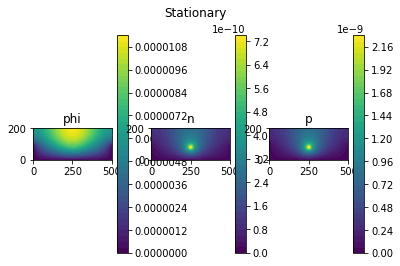

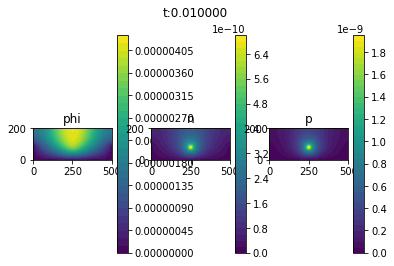

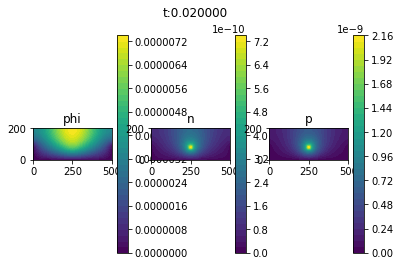

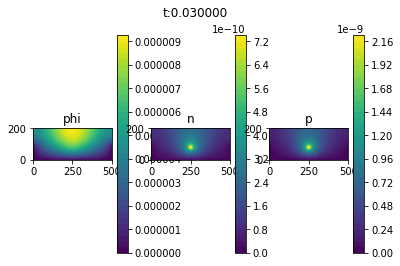

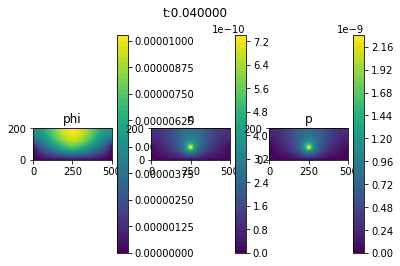

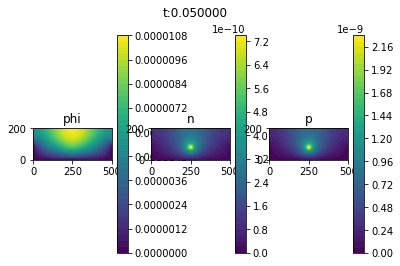

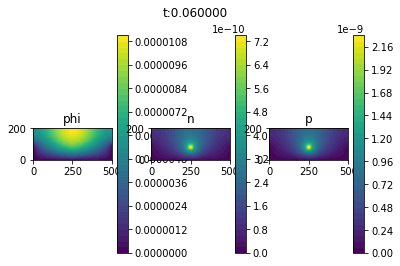

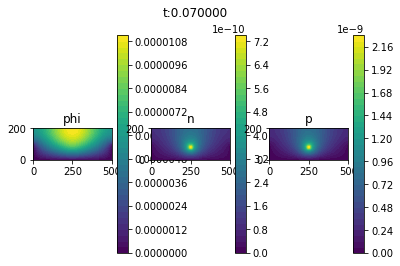

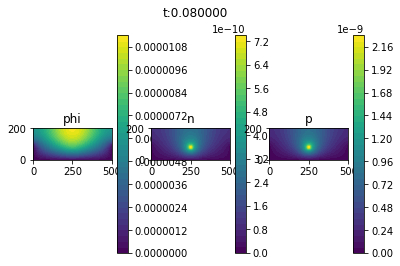

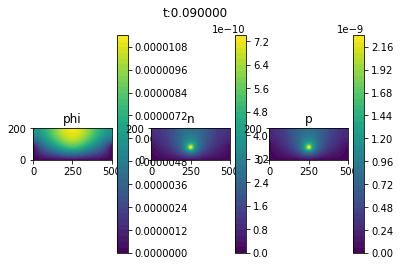

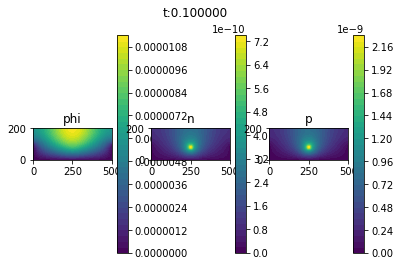

In [4]:
parameters["ghost_mode"] = "shared_facet"


def read_h5(filename = 'file.h5'):
	'''Description: Convert mesh written in XML format into H5 format
	   Write mesh tags (boundaries, domains) into H5 file
	   Input:  XML mesh
	   Output: H5 mesh
	'''
	mesh = Mesh()
	hdf = HDF5File(mesh.mpi_comm(), filename, "r")
	hdf.read(mesh, "/mesh", False)
	dim = mesh.topology().dim()
	cell_markers = MeshFunction("size_t", mesh, dim)
	hdf.read(cell_markers, "/cell_markers")
	facet_markers = MeshFunction("size_t", mesh, dim-1)
	hdf.read(facet_markers, "/facet_markers")
	return mesh, cell_markers, facet_markers






# =========================== Defined Sources ===========================
Bx = 250.0;
By = 80.0;
sigma_x = 10.0;
sigma_y = 10.0

#Sn_str = '(I_0/(q_e*pow(2.0*pi,3.0/2.0)*sigma_x*sigma_y*sigma_z))*exp( -source_cof*(pow((x[0] - Bx)/sigma_x, 2.0) + pow((x[1] - By)/sigma_y, 2.0) + pow((x[2] - Bz)/sigma_z, 2.0) ) )'
Sn_str = '(I_0/(qe*pow(2.0*pi,3.0/2.0)*sigma_x*sigma_y))*exp( -source_cof*(pow((x[0] - Bx)/sigma_x, 2.0) + pow((x[1] - By)/sigma_y, 2.0) ) )'
Sn = Expression( Sn_str, degree = 1, I_0 = I_0, qe = qe, pi = math.pi, Bx = Bx, By = By, sigma_x = sigma_x, sigma_y = sigma_y, source_cof = source_cof)

Sp = Sn;
Sp.I_0 = 1E-5*I_0;
Sphi = Constant(0.0)




# =========================== Load Mesh ===========================
# clone my repository
! git clone --recursive 'https://github.com/DuyDucNguyen/Practical_FEM_FEniCS_Colab/'
! ls

# load mesh
mesh_name = 'Practical_FEM_FEniCS_Colab/Geometry/2D_specimen_vacuum.h5'
mesh, cell_markers, facet_markers = read_h5(mesh_name)


# define subdomains and cell measurement
dx = Measure("dx", domain = mesh, subdomain_data = cell_markers)

# define interface and facet measurement
dS = Measure("dS", domain = mesh, subdomain_data = facet_markers)




# =========================== Define Finite Element ===========================
degree = 1
# CG: Continuous Galerkin
fi_ele   = FiniteElement('CG', mesh.ufl_cell(), degree)
elements = MixedElement([fi_ele, fi_ele, fi_ele])
W        = FunctionSpace(mesh, elements)




# =========================== Define Unks ===========================
# Define trial function
dunks = TrialFunction(W); (dphi, dn, dp) = split(dunks)

# Define Functions
unks = Function(W, name='(phi; n; p)'); (phi, n, p) = split(unks);

# Define Test Functions (tf)
tests = TestFunction(W); (tphi, tn, tp) = split(tests);



# =========================== Define Tags ===========================
# GMSH tag names
semi_topsur_tag = 1 # Interface tag name
semi_other_tags = [2, 3, 4]

vac_topsur_tag = 5 # detector tag name
vac_other_tags = [6, 7]



# =========================== Dirichlet Boundary Conditions ===========================
ni_semi = Si['ni']
pi_semi = Si['pi']


# Dirichlet BC for phi, n, p:
phi_Dbcs = [DirichletBC(W.sub(0), Constant(0.0), facet_markers, bc) for bc in [2, 3, 4]]
n_Dbcs = [DirichletBC(W.sub(1), ni_semi, facet_markers, bc) for bc in [2, 3, 4]]
p_Dbcs = [DirichletBC(W.sub(2), pi_semi, facet_markers, bc) for bc in [2, 3, 4] ]
Dbcs = phi_Dbcs + n_Dbcs + p_Dbcs

ni = Si['ni']
pi = Si['pi']


# Define initial conditions
phi0_ = interpolate( Expression( ('phi0'), phi0=Constant(0.0), degree=1 ), W.sub(0).collapse() )
n0_ = interpolate( Expression( ('n0'), n0=ni, degree=1 ), W.sub(1).collapse() )
p0_ = interpolate( Expression( ('p0'), p0=pi, degree=1 ), W.sub(2).collapse() )

unks0 = Function(W)
assign(unks0, [phi0_, n0_, p0_])
(phi0, n0, p0) = split(unks0)


# Time Scheme
theta = 1.0
phim = theta*phi + (1.0-theta)*phi0
nm = theta*n + (1.0-theta)*n0
pm = theta*p + (1.0-theta)*p0


unksm = theta*unks + (1.0-theta)*unks0


eps_semi = Si['eps']
Mun_semi = Si['Mun']
Dn_semi = Si['Dn']
Mup_semi = Si['Mup']
Dp_semi = Si['Dp']




# =========================== Define Stationary F  ===========================
def vd(phi, Mu):
	''' Drift velocity '''
	return Mu*grad(-phi)


def jn0(n, phi, Mu, D):
	''' Electron current density in Semi body'''
	return  n*( -vd(phi, Mu) ) - D*grad(n)


def jp0(p, phi, Mu, D):
	''' Hole current density in Semi body '''
	return  p*vd(phi, Mu) - D*grad(p)


def jn1(n, phi, Mu):
	''' Electron current density in Vacuum'''
	D = einstein_relation(Mu)
	return  n*( -vd(phi, Mu) ) - 1.0*D*grad(n)



def R_func(n, p, ni, pi):
	''' Recombination '''
	# internet
	#R = (pm*nm-ni*ni)/( tau_p*(nm + n_1) + tau_n*(pm + p_1))
	# raftari2015
	R = (n*p-ni*ni)/( tau_p*(n + ni) + tau_n*(p + pi))
	return R


def R_func2(n, p, nn, pp, ni, pi):
	''' Recombination '''
	R = (n*p - ni*ni)/( tau_p*(nn + ni) + tau_n*(pp + pi))
	return R


def norm(u):
	return sqrt( dot( u, u ) )


F_dphi = eps_semi*dot(grad(dphi), grad(tphi))*dx \
	 - (qe/eps0)*(dp - dn)*tphi*dx \


F_dn = - dot( dn*( -vd(dphi, Mun_semi) ) - Dn_semi*grad(dn), grad(tn) )*dx \
	- ( Sn - R_func2(dn, dp, dn, dp, ni_semi, pi_semi) )*tn*dx \


F_dp = - dot( dp*vd(dphi, Mup_semi) - Dp_semi*grad(dp), grad(tp) )*dx \
	- ( Sp - R_func2(dn, dp, dn, dp, ni_semi, pi_semi) )*tp*dx \

F_dunks = F_dphi + F_dn + F_dp

F_dunksm = action( F_dunks, unksm )


# =========================== Solving Stationary Problem ===========================
solve(F_dunksm == 0 , unks, Dbcs )
_phi, _n, _p = unks.split(True)

plt.figure()
plt.suptitle("Stationary");
plt.subplot(1,3,1);
p1 = plot(_phi)
plt.title('phi')
plt.colorbar(p1)

plt.subplot(1,3,2);
p2 = plot(_n)
plt.title('n')
plt.colorbar(p2)

plt.subplot(1,3,3);
p3 = plot(_p)
plt.title('p')
plt.colorbar(p3)





# =========================== Define Dynamic F  ===========================
t_end = 0.1
dt = 0.01
t = 0.0
t = t + dt

dyF_dn = F_dn + (dn-n0)/dt*tn*dx
dyF_dp = F_dp + (dp-p0)/dt*tp*dx

dyF = F_dphi + dyF_dn + dyF_dp

dyFm = action( dyF, unksm )


# =========================== Solving Dynamic Problem ===========================

while t <= t_end:
	print('\nt:', t, '\n')
	# solve the problem
	solve(dyFm == 0 , unks, Dbcs )
	_phi, _n, _p = unks.split(True)


	plt.figure();
	plt.suptitle("t:%f"%(t));
	plt.subplot(1,3,1);
	p1 = plot(_phi)
	plt.title('phi')
	plt.colorbar(p1)

	plt.subplot(1,3,2);
	p2 = plot(_n)
	plt.title('n')
	plt.colorbar(p2)

	plt.subplot(1,3,3);
	p3 = plot(_p)
	plt.title('p')
	plt.colorbar(p3)

	# Update time step
	t = t + dt
	unks0.assign(unks)


plt.show()


